In [86]:
import numpy as np 
import pandas as pd 
import math
import uncertainties
from uncertainties import ufloat_fromstr
from uncertainties import unumpy as unp
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy import stats
from scipy . optimize import curve_fit
from scipy . interpolate import interp1d
from scipy import optimize

# --- plot parameters --- 
plt.rcParams["figure.figsize"] = (15,10)
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({'font.size': 22})

In [87]:
# --- Importing data from .csv -- 

# --- Importing data from table 1 provided in raw data word document ---  

part_1 = pd.read_csv('data\Compton_scattering_formula_and_differential_cross_section.csv')

part_2 = pd.read_csv('data\compton_scattering_electron_mass_rel.csv')

In [88]:
part_1

,Angle,Counting_time,scattered_gamma_ray_energy,scattered_gamma_ray_energy_uncer,photopeak_net_area,photopeak_net_area_uncer
0,20,158.56,597,56,12616,343
1,25,221.78,573,65,15240,430
2,30,290.38,549,55,17925,456
3,35,208.42,518,50,10484,368
4,40,318.50,487,54,15680,467
5,45,307.54,470,55,13043,437
6,50,390.84,439,54,14791,499
7,55,706.66,416,52,24188,598
8,60,446.52,390,49,14105,474
9,65,466.00,371,44,14757,460


In [89]:
# --- Variable Definition --- 

# --- Part 1 --- 

angle = part_1['Angle']
counts_time = np.array(part_1['Counting_time'])
gamma_ray_energy = part_1['scattered_gamma_ray_energy']
gamma_ray_uncer = part_1['scattered_gamma_ray_energy_uncer']
photopeak_area = part_1['photopeak_net_area']
photopeak_uncer = part_1['photopeak_net_area_uncer']

# --- conversion and uncertainty coupling --- 



angle = unp.uarray(angle, 1)
gamma_rays = unp.uarray(gamma_ray_energy, gamma_ray_uncer)*0.001 # conversion from KeV to MeV 
photopeak = unp.uarray(photopeak_area, photopeak_uncer) 

print(photopeak)

angle_r = angle*(np.pi/180)

[12616.0+/-343.0 15240.0+/-430.0 17925.0+/-456.0 10484.0+/-368.0
 15680.0+/-467.0 13043.0+/-437.0 14791.0+/-499.0 24188.0+/-598.0
 14105.0+/-474.0 14757.0+/-460.0 10067.0+/-393.0 19027.0+/-470.0
 11828.0+/-383.0 10227.0+/-347.0 73551.0+/-1082.0]


In [90]:
# -- function definition --- 

def lin_func(x, m, c):
    return m*x + c #equation of a line y = mx + c 

def exp(x, a, b):
    return a*np.exp(-b*x)

# - differential cross section - 

def Klein_Nishina(theta):
    r = 2.82e-13
    alpha = 1.29
    A = (r**2/2)*((1 + np.cos(theta)**2)/(1 + alpha*(1 - np.cos(theta)**2)))
    t = (alpha**2)*(1 - np.cos(theta))**2
    b = (1 + np.cos(theta)**2)*(1 + alpha*(1 - np.cos(theta)))
    B = t/b
    return A*B 


def gamma_sum(energy, photopeak, counting_time):
    peak_eff = .1522*(energy)**-1.1325
    return (photopeak/counting_time)/peak_eff
    

def diff_cross(gamma_sum):
    t = 42.583 # time in years from August of 1977 to March 2020, when data was taken. 
    I = 1.013e6*np.exp(-t/43.48) 
    delta_omega = np.pi/26**2
    N = ((79.3)*(6.0221409e+23)*(13))/27
    return gamma_sum/(I*delta_omega*N)



In [91]:
def KleinNishina (ang) : #in cm squared / steradians
    alpha = 1.29
    r = 2.82e-13
    return ((r**2) /2)*((1+(np.cos(ang))**2)/(1+((alpha)*(1 - np.cos(ang))))**2)*(1+( (alpha**2)*((1 - np.cos(ang))**2) /(1+(np.cos(ang))**2)*(1+((alpha)*(1 - np.cos(ang))))))

In [92]:
def KleinNishina (ang) : #in cm squared / steradians
    alpha = 1.29
    part1a = (1+(np.cos(ang))**2)
    part1b = (1+((alpha)*(1 - np.cos(ang))))**2
    part2a = (alpha**2)*((1 - np.cos(ang))**2)
    part2b = (1+(np.cos(ang))**2)*(1+((alpha)*(1 - np.cos(ang))))
    r0 = 2.82e-13
    return ((r0**2) /2)*(part1a/part1b)*(1+( part2a /part2b))

## Energy of the Scattered Photon as a Function of the Scattering Angle

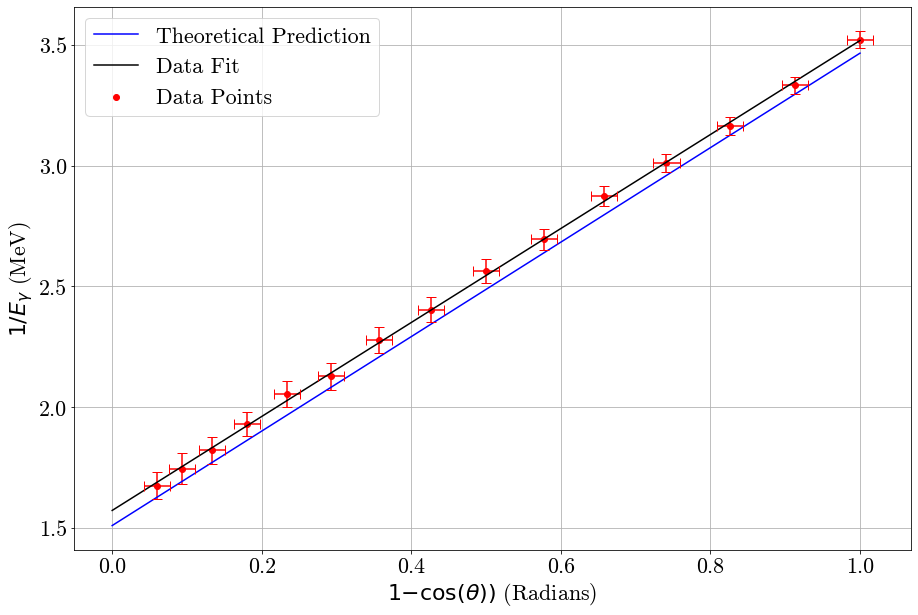

In [93]:
# --- setting up data for graphing  -- 

y = 1/unp.nominal_values(gamma_rays)
yerr = unp.std_devs(gamma_rays)  

x = 1 - np.cos(unp.nominal_values(angle_r))
xerr = unp.std_devs(angle_r)

x_fit = np.linspace(0, x.max(), 10)

# --- fitting data for graph --- 

popt1, pcov1 = curve_fit(lin_func, x, y)
fit_data = lin_func(x_fit, popt1[0], popt1[1])

# --- Theoretical Fit --- 

th_data = lin_func(x_fit, 1.956, 1.51)

# --- plotting --- 

plt.plot(x_fit, th_data, 'blue', label = 'Theoretical Prediction')
plt.plot(x_fit, fit_data, 'black', label = 'Data Fit')
plt.errorbar(x, y, xerr = xerr, yerr = yerr, capsize= 5, ls='none', color = 'red')
plt.scatter(x, y, color = 'red', label = 'Data Points')

plt.xlabel('$1 − \cos (\\theta ))$ (Radians)')
plt.ylabel('$1/E_\gamma$ (MeV)')


plt.grid()
plt.legend()
plt.savefig('images/angle_vs_gammaray.png')

In [94]:
# --- Slope of Curve --- 

print('The slope of the above curve is:', "{:.3f}".format(popt1[0]))

# --- Finding Intercept --- 

x = 0
y = (popt1[0]*x) + popt1[1]
print('y-intercept of the line:', "{:.3f}".format(y))

# --- Comparison with theoretical values --- 

print('The slope of the fitted data is', "{:.3f}".format(1.956/popt1[0] - 1),'% greater than predicted value for slope.')

xth = 0
yth = (1.956*x) + 1.51
print('y-intercept of the theoretical line is:', "{:.3f}".format(yth))

print('y-intercept of the fitted data is', "{:.3}".format(y/yth - 1),'% greater than predicted value for slope.')

The slope of the above curve is: 1.946
y-intercept of the line: 1.573
The slope of the fitted data is 0.005 % greater than predicted value for slope.
y-intercept of the theoretical line is: 1.510
y-intercept of the fitted data is 0.0414 % greater than predicted value for slope.


## Differential Cross Sections for Compton Scattering of Cs (137)

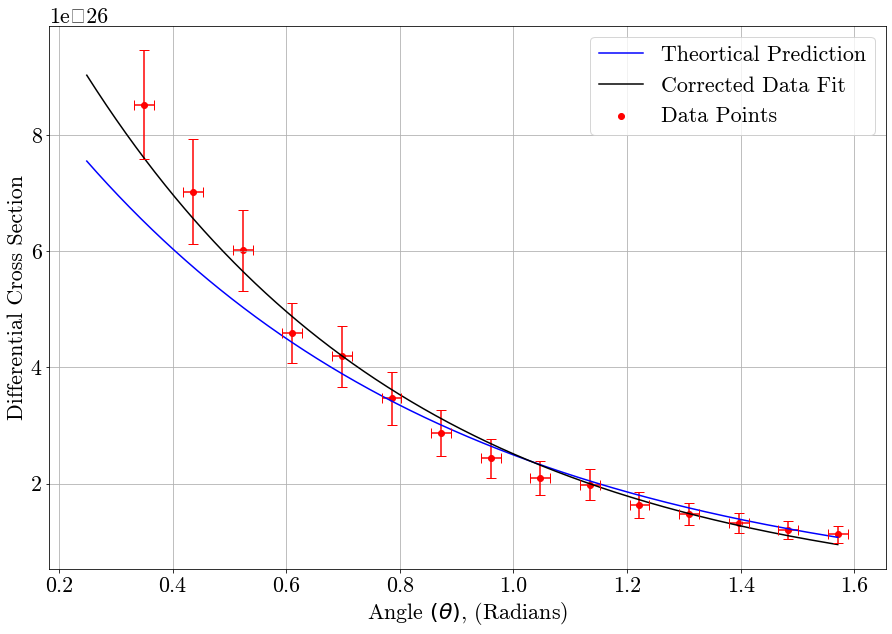

In [95]:
# --- data for graph --- 

x = unp.nominal_values(angle_r)
xerr = unp.std_devs(angle_r)

p1 = gamma_sum(gamma_rays, photopeak, counts_time)
# print(p1)
p2 = diff_cross(p1)
# print(p2)


# --- theortical model --- 

yth = KleinNishina(x)

# -- 
correction_factor = (yth/p2).mean()
# --

p2 = diff_cross(p1)*correction_factor

y = unp.nominal_values(p2)
y_err = unp.std_devs(p2)

# --- fitting function --- 

x_s = np.linspace(x.min() - .1, x.max(), 1000)

popt1, pcov1 = curve_fit(exp, x, y, sigma = y_err, absolute_sigma = True, p0 = [1e-26, 2])
fit_data = exp(x_s, popt1[0], popt1[1])

# --- 

popt2, pcov2 = curve_fit(exp, x, yth, p0 = [7e-26, .7])
th_data = exp(x_s, popt2[0], popt2[1])

# --- Plotting ---

plt.plot(x_s, th_data, label = 'Theortical Prediction', color = 'blue')
plt.scatter(x, y, label = 'Data Points ', color = 'red')
plt.plot(x_s, fit_data, label = 'Corrected Data Fit', color = 'black')
plt.errorbar(x, y, xerr = xerr, yerr = y_err, capsize= 5, ls='none', color = 'red')

plt.xlabel('Angle $(\\theta )$, (Radians)')
plt.ylabel('Differential Cross Section')

plt.legend()
plt.grid()
plt.savefig('images/angle_vs_cross_section.png')

In [96]:
# --- Variable Compile --- 

x = unp.nominal_values(angle_r)
xerr = unp.std_devs(angle_r)
yth = KleinNishina(x)
y = unp.nominal_values(p2)
y_err = unp.std_devs(p2)
percent = (y/yth - 1)*100
# print(percent)

print(stats.chisquare(f_obs=y, f_exp=yth))

# --- write to .csv --- 

Output = [x, xerr, y*1e26, y_err*1e26, yth*1e26, percent]

# print(Output)
dataset = pd.DataFrame({'Angle': np.round(Output[0], 3), 'Angle_Error': np.round(Output[1], 3), 'Diff_Cross_Section': np.round(Output[2], 3), 'Diff_Cross_Section_Uncer': np.round(Output[3], 3), 'Diff_Cross_Section_Th': np.round(Output[4], 3), 'Percent': np.round(Output[5], 1)})
print(dataset)

print(dataset.to_latex(index=False)) 
dataset.to_csv('data/theor_compare.csv')

Power_divergenceResult(statistic=1.193910093135015e-26, pvalue=1.0)
    Angle  Angle_Error  Diff_Cross_Section  Diff_Cross_Section_Uncer  \
0   0.349        0.017               8.527                     0.936   
1   0.436        0.017               7.030                     0.906   
2   0.524        0.017               6.017                     0.692   
3   0.611        0.017               4.591                     0.517   
4   0.698        0.017               4.189                     0.527   
5   0.785        0.017               3.467                     0.459   
6   0.873        0.017               2.863                     0.395   
7   0.960        0.017               2.437                     0.336   
8   1.047        0.017               2.090                     0.293   
9   1.134        0.017               1.980                     0.264   
10  1.222        0.017               1.630                     0.217   
11  1.309        0.017               1.471                     0.187

# Part II 

In [97]:
part_2

,Source,Photopeak,Photopeak_Uncertainty,Compton_Edge,Compton_Edge_Uncertainty
0,Na-22,510,2,338,6
1,Na-22,1275,2,1062,10
2,K-40,1457,2,1240,7
3,Mn-54,833,2,637,4
4,Co-56,1236,2,1025,5
5,Co-57,123,2,39,3
6,Co-60,1173,2,963,5
7,Co-60,1332,2,1118,4
8,In-116,417,2,263,6
9,In-116,1098,2,890,10


In [98]:
# --- Loading Data --- 

sources = part_2['Source']
photopeak = part_2['Photopeak']
photopeak_uncer = part_2['Photopeak_Uncertainty']
compton_edge = part_2['Compton_Edge']
compton_edge_uncer = part_2['Compton_Edge_Uncertainty']

# --- converting data and coupling --- 

photopeak = unp.uarray(photopeak, photopeak_uncer)*0.001 
compton_edge = unp.uarray(compton_edge, compton_edge_uncer)*0.001  

### Compton Edge vs. Incident Photon Energies

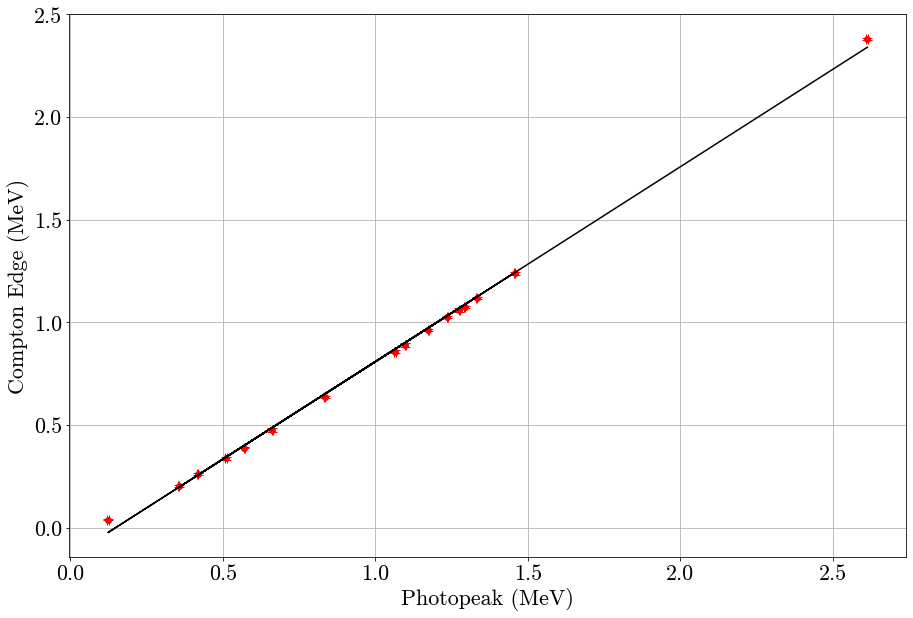

In [99]:
x = unp.nominal_values(photopeak)
y = unp.nominal_values(compton_edge)
x_err = unp.std_devs(photopeak)
y_err = unp.std_devs(compton_edge)

# --- Fitting --- 

popt1, popc1 = curve_fit(lin_func, x, y)
fit_data = lin_func(x, popt1[0], popt1[1])

# --- Plotting ---

plt.scatter(x, y, color = 'red')
plt.errorbar(x, y, xerr = x_err, yerr = y_err, capsize= 5, ls='none', color = 'red')
plt.plot(x, fit_data, color = 'black')
plt.grid()
plt.xlabel('Photopeak (MeV)') 
plt.ylabel('Compton Edge (MeV)') 
plt.savefig('images/photo_peak_vs_compton_edge.png')

In [100]:
# --- Slope of Curve --- 

print('The slope of the above curve is:', "{:.3f}".format(popt1[0]))

# --- Finding Intercept --- 

x = 0
y = (popt1[0]*x) + popt1[1]
print('y-intercept of the line:', "{:.3f}".format(y))

The slope of the above curve is: 0.949
y-intercept of the line: -0.140


## Classical vs. Realtivistic 

In [101]:
def classical_energy(gamma_energy, compton_edge):
    return ((2*gamma_energy - compton_edge)**2)/(2*compton_edge)

def rel_energy(gamma_energy, compton_edge): 
    return 2*gamma_energy*(gamma_energy - compton_edge)/compton_edge

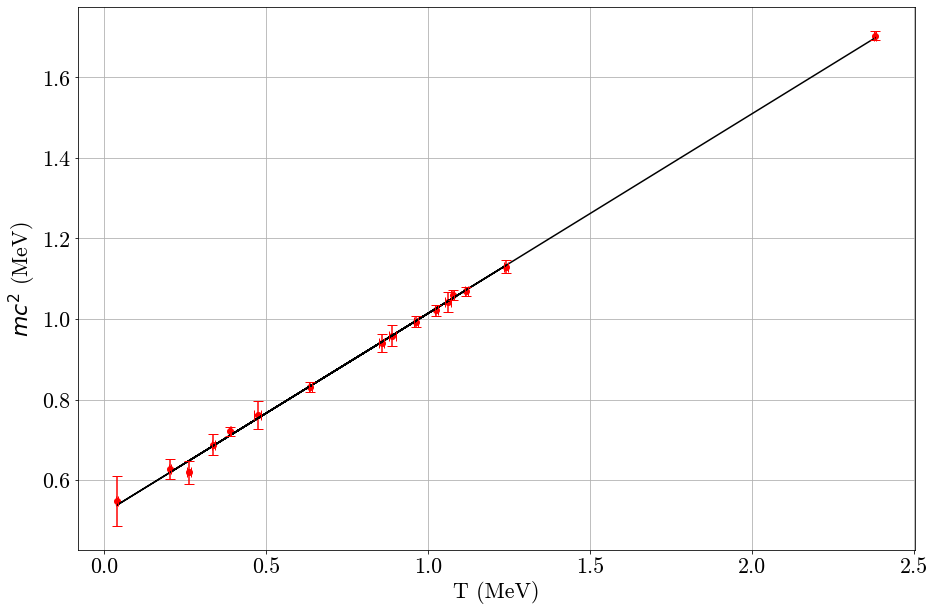

In [102]:
x = unp.nominal_values(compton_edge)
x_err = unp.std_devs(compton_edge)

clre = classical_energy(photopeak, compton_edge)

y = unp.nominal_values(clre)
y_err = unp.std_devs(clre)

# --- Fitting --- 

popt1, popc1 = curve_fit(lin_func, x, y)
fit_data = lin_func(x, popt1[0], popt1[1])

plt.plot(x, fit_data, color = 'black')
plt.scatter(x, y, color = 'red')
plt.errorbar(x, y, xerr = x_err, yerr = y_err, capsize= 5, ls='none', color = 'red')
plt.xlabel('T (MeV)')
plt.ylabel('$mc^2$ (MeV)')
plt.grid()
plt.savefig('images/electron_cl.png')

In [103]:
# --- Slope of Curve --- 

print('The slope of the above curve is:', "{:.3f}".format(popt1[0]))

# --- Finding Intercept --- 

x = 0
y = (popt1[0]*x) + popt1[1]
print('y-intercept of the line:', "{:.3f}".format(y))

The slope of the above curve is: 0.496
y-intercept of the line: 0.518


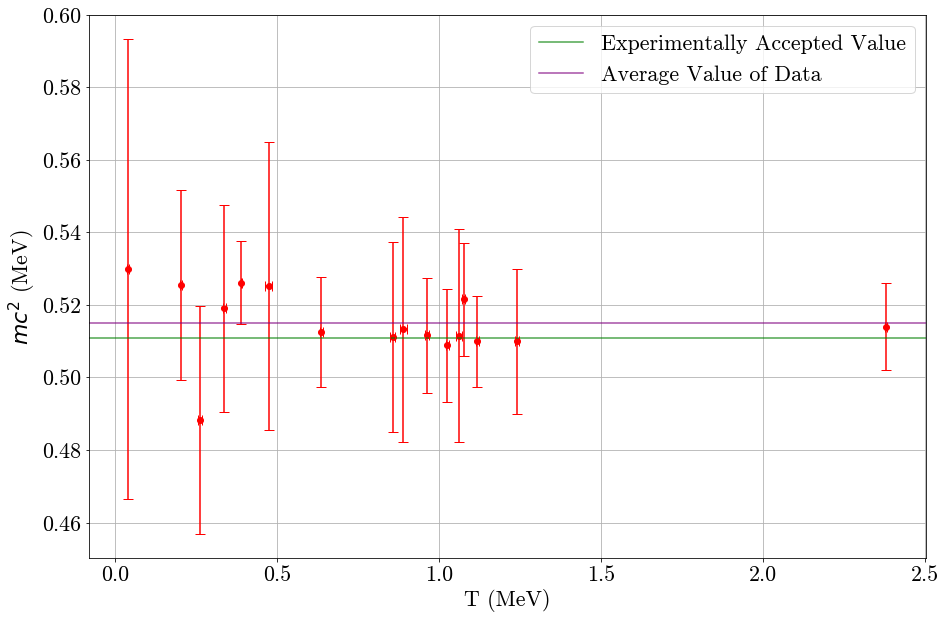

In [104]:
x = unp.nominal_values(compton_edge)
x_err = unp.std_devs(compton_edge)

relre = rel_energy(photopeak, compton_edge)
ovr_err = relre.mean()

y = unp.nominal_values(relre)
y_err = unp.std_devs(relre)

# --- Accepted Value of rest mass --- 
#0.5110 MeV

plt.axhline(y = 0.511, color = 'green', alpha = .7, label = 'Experimentally Accepted Value')

# --- comparing to average values --- 

plt.axhline(y = y.mean(), color = 'purple', alpha = .7, label = 'Average Value of Data')

plt.scatter(x, y, color = 'red')
plt.errorbar(x, y, xerr = x_err, yerr = y_err, capsize= 5, ls='none', color = 'red')
plt.grid()
plt.xlabel('T (MeV)')
plt.ylabel('$mc^2$ (MeV)')
plt.legend()
plt.savefig('images/electron_rel.png')

In [105]:
print('Average rest energy', '{:.3f}'.format(ovr_err), 'MeV')
print('The difference in rest energy between experimental data and the accepted value is', '{:.3f}'.format(y.mean() - 0.511), 'MeV, this is a differnce of', '{:.3f}'.format(0.511/y.mean()), '%')
print('Errors on the y-values',  '{:.3f}'.format(y_err.mean()))

Average rest energy 0.515+/-0.007 MeV
The difference in rest energy between experimental data and the accepted value is 0.004 MeV, this is a differnce of 0.992 %
Errors on the y-values 0.025


## Other Relativistic Attributes 

In [106]:
def electron_velocity(E, T):
    return (T*(2*E - T))/(T**2 - 2*E*T + 2*E**2)

def relativistic_factor(E, T):
    return 1 + ((T**2)/(2*E*(E - T)))

def total_energy(E, T):
    return (T**2 - 2*T*E + 2*E**2)/(T)

def momentum(E, beta):
    return E*beta

In [107]:
beta = electron_velocity(photopeak, compton_edge)
gamma = relativistic_factor(photopeak, compton_edge)
E = total_energy(photopeak, compton_edge)
pc = momentum(E, beta)

# --- Writing data to CSV --- 

Output = [sources, unp.nominal_values(beta), unp.std_devs(beta), unp.nominal_values(gamma), unp.std_devs(gamma), unp.nominal_values(clre), unp.std_devs(clre), unp.nominal_values(relre), unp.std_devs(relre), unp.nominal_values(E), unp.std_devs(E)]

# print(Output)
dataset = pd.DataFrame({'Source': Output[0], 'beta_values': np.round(Output[1], 3), 'beta_uncertainties': np.round(Output[2], 3), 'Gamma_values': np.round(Output[3], 3), 'Gamma_uncertainties': np.round(Output[4], 3), 'Classical_Rest_Energy_MeV': np.round(Output[5], 3), 'Classical_Rest_Energy_uncertainties_MeV': np.round(Output[6], 3), 'Relativistic_Rest_Energy_MeV': np.round(Output[7], 3), 'Relativistic_Rest_Energy_uncertainties_MeV': np.round(Output[8] , 3), 'Total_Energy': np.round(Output[9], 3), 'Total_Energy_Uncer': np.round(Output[10], 3)})
# print(dataset)
print(dataset.to_latex(index=False))
dataset.to_csv('data/relativistic_relations.csv')

\begin{tabular}{lrrrrrrrrrr}
\toprule
Source &  beta\_values &  beta\_uncertainties &  Gamma\_values &  Gamma\_uncertainties &  Classical\_Rest\_Energy\_MeV &  Classical\_Rest\_Energy\_uncertainties\_MeV &  Relativistic\_Rest\_Energy\_MeV &  Relativistic\_Rest\_Energy\_uncertainties\_MeV &  Total\_Energy &  Total\_Energy\_Uncer \\
\midrule
 Na-22 &        0.796 &               0.013 &         1.651 &                0.047 &                      0.688 &                                    0.026 &                         0.519 &                                       0.028 &         0.857 &               0.023 \\
 Na-22 &        0.946 &               0.005 &         3.076 &                0.138 &                      1.042 &                                    0.024 &                         0.511 &                                       0.029 &         1.573 &               0.020 \\
  K-40 &        0.957 &               0.003 &         3.432 &                0.109 &                      1.13

## Relativistic Plots

In [108]:
def unique_fit(x, a, b, c):
    return 1/np.sqrt(a + b*x**2) + c

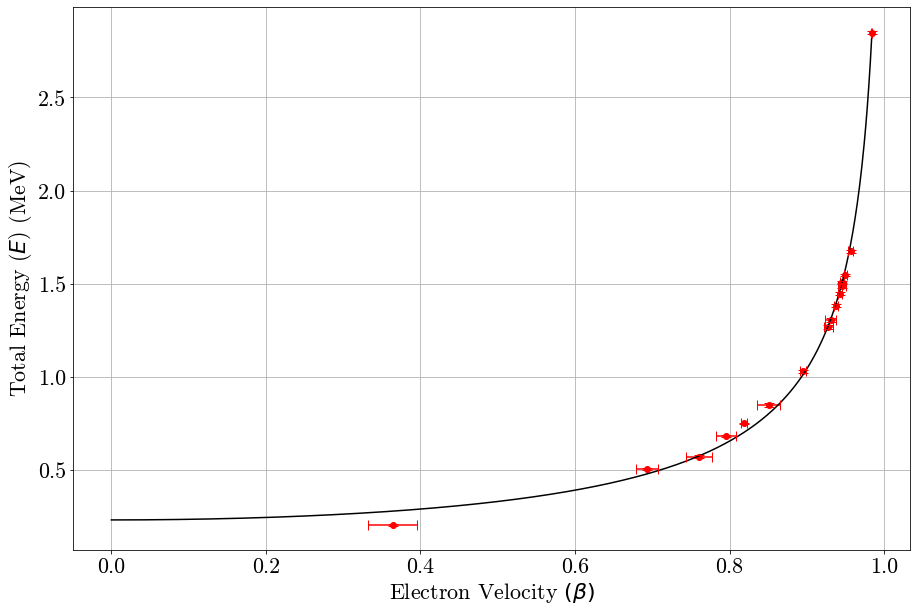

In [109]:
x = unp.nominal_values(beta)
y = unp.nominal_values(pc)
x_err = unp.std_devs(beta)
y_err = unp.std_devs(pc)

plt.ylabel('Total Energy ($E$) (MeV)')
plt.xlabel('Electron Velocity $( \\beta )$')

# --- fitting function --- 

x_s = np.linspace(0, x.max(), 1000)

popt1, pcov1 = curve_fit(unique_fit, x, y, sigma = y_err, absolute_sigma = True, p0 = [.1, 3, 1])
fit_data = unique_fit(x_s, popt1[0], popt1[1], popt1[2])

plt.plot(x_s, fit_data, color = 'black')
plt.scatter(x, y, color = 'red')
plt.errorbar(x, y, xerr = x_err, yerr = y_err, capsize= 5, ls='none', color = 'red')
plt.grid()
plt.savefig('images/E_vs_Velocity')

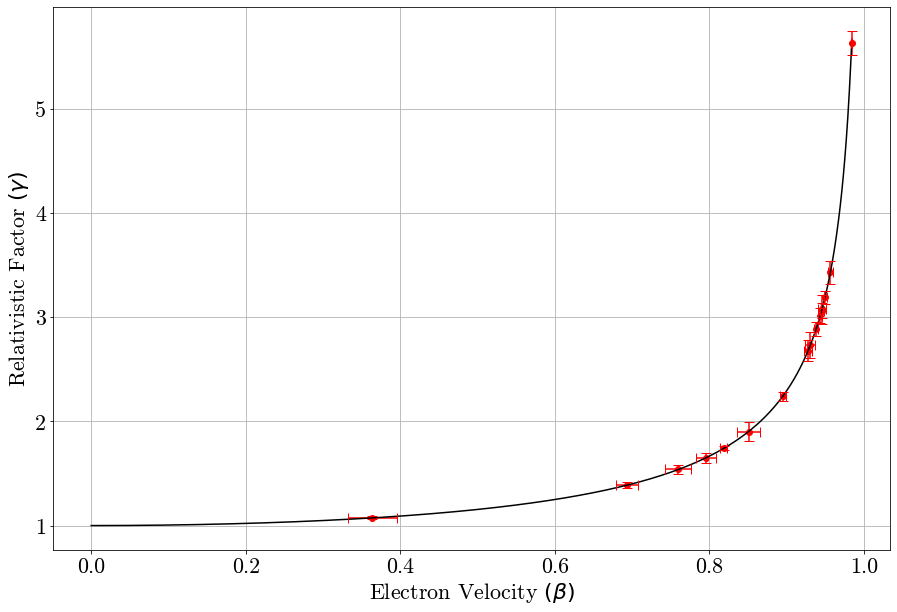

In [110]:
x = unp.nominal_values(beta)
y = unp.nominal_values(gamma)
x_err = unp.std_devs(beta)
y_err = unp.std_devs(gamma)

# --- fitting function --- 

x_s = np.linspace(0, x.max(), 1000)

popt1, pcov1 = curve_fit(unique_fit, x, y, sigma = y_err, absolute_sigma = True, p0 = [.1, 3, 1])
fit_data = unique_fit(x_s, popt1[0], popt1[1], popt1[2])

plt.plot(x_s, fit_data, color = 'black')

plt.scatter(x, y, color = 'red')
plt.errorbar(x, y, xerr = x_err, yerr = y_err, capsize= 5, ls='none', color = 'red')

plt.grid()
plt.ylabel('Relativistic Factor $(\gamma)$')
plt.xlabel('Electron Velocity $( \\beta )$')
plt.savefig('images/RelFactor_vs_Velocity')